# Cải tiến mô hình với dữ liệu được lọc theo cự ly

In [1]:
import os
import random
import datetime
import time
import math
import subprocess
from glob import glob
import operator
import numpy as np
import pandas as pd
from collections import Counter

import scipy.stats as ss
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras import backend as K
import keras

from tensorflow.keras.layers import Dense, Input, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping, CSVLogger
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.initializers import RandomNormal, Constant
from tensorflow.keras.metrics import Metric
import tensorflow.keras.optimizers as Optimizer
import tensorflow_addons as tfa 

import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os.path as path
lib_path =  path.abspath(path.join('' ,"../../api/common"))
sys.path.insert(1, lib_path)
from transform_split_data import transform_split_data
from predict import predict, evaluate

%load_ext autoreload
%autoreload 2
%load_ext autotime
%load_ext tensorboard
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

time: 16 ms


- Khởi tạo phương thức giải phóng bộ nhớ gpu

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs
time: 734 ms


## 1. Load data

In [3]:
# Load dữ liệu
train_data = pd.read_csv('train_data_all.csv')
train_data

,race_id,KettoNum,id$Year,ChokyosiCode,BanusiCode,UM_BreederCode,Odds,Kyori,TenkoBaba$DirtBabaCD_0,TenkoBaba$SibaBabaCD_0,...,KS_Syotai_川崎,KS_Syotai_笠松,id$JyoCD_1,KS_ChokyosiCode_365.0,CH_Syotai_川崎,top2_ChokyosiCode,top2_BanusiCode,top2_UM_BreederCode,before_Odds,speed
0,12135,2009100729,2011,1010,949030,600016,222,-1.045283,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.352506,-0.921203,0.090456,0.243086,59.833795
1,26439,2011103176,2015,1095,477030,100046,35,0.166752,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.254953,-0.661138,-0.651838,-0.672843,58.230257
2,33661,2013100779,2017,1123,78006,703397,148,2.348416,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.206765,-0.442809,-1.241063,-0.613398,57.920792
3,28482,2011105992,2016,1129,547800,610012,52,1.378788,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.453573,-0.510523,-0.974169,-0.578217,60.876249
4,291,2004104307,2008,331,142006,701079,933,0.166752,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,-1.477666,-1.938882,-0.988132,0.072652,57.627119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475191,18201,2005106482,2013,1013,789006,400018,911,3.027155,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.232084,-0.467961,0.392597,3.096416,49.966265
475192,7309,2006102916,2010,1076,310007,393126,369,-1.530097,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,-0.380029,0.211269,1.335489,-0.553954,60.301508
475193,16882,2007104657,2012,1102,103006,330314,63,-1.045283,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.541780,-1.376219,-0.335163,-0.299192,62.113587
475194,8963,2007104503,2010,221,100006,310390,109,-1.530097,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,-1.098465,-0.945524,-1.037796,-0.678908,60.050042


time: 8.95 s


- Lọc dữ liệu train theo cự ly

In [4]:
filter_Kyori_id = pd.read_csv('filter_Kyori_id.csv')
filter_Kyori_id

,race_id,KettoNum
0,1,2005107051
1,1,2005102028
2,1,2005104156
3,1,2005105319
4,1,2005101044
...,...,...
452048,34534,2012101892
452049,34534,2013104774
452050,34534,2012101704
452051,34534,2012102404


time: 110 ms


In [5]:
new_train_data = pd.merge(filter_Kyori_id, train_data, on=['race_id', 'KettoNum'], how='right', indicator=True)
new_train_data

,race_id,KettoNum,id$Year,ChokyosiCode,BanusiCode,UM_BreederCode,Odds,Kyori,TenkoBaba$DirtBabaCD_0,TenkoBaba$SibaBabaCD_0,...,KS_Syotai_笠松,id$JyoCD_1,KS_ChokyosiCode_365.0,CH_Syotai_川崎,top2_ChokyosiCode,top2_BanusiCode,top2_UM_BreederCode,before_Odds,speed,_merge
0,12135,2009100729,2011,1010,949030,600016,222,-1.045283,1.0,0.0,...,0.0,0.0,0.0,0.0,-1.352506,-0.921203,0.090456,0.243086,59.833795,both
1,26439,2011103176,2015,1095,477030,100046,35,0.166752,0.0,1.0,...,0.0,0.0,0.0,0.0,0.254953,-0.661138,-0.651838,-0.672843,58.230257,both
2,33661,2013100779,2017,1123,78006,703397,148,2.348416,1.0,0.0,...,0.0,0.0,0.0,0.0,-0.206765,-0.442809,-1.241063,-0.613398,57.920792,both
3,28482,2011105992,2016,1129,547800,610012,52,1.378788,1.0,0.0,...,0.0,0.0,0.0,0.0,0.453573,-0.510523,-0.974169,-0.578217,60.876249,both
4,291,2004104307,2008,331,142006,701079,933,0.166752,0.0,1.0,...,0.0,0.0,0.0,0.0,-1.477666,-1.938882,-0.988132,0.072652,57.627119,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475191,18201,2005106482,2013,1013,789006,400018,911,3.027155,0.0,0.0,...,0.0,0.0,0.0,0.0,0.232084,-0.467961,0.392597,3.096416,49.966265,right_only
475192,7309,2006102916,2010,1076,310007,393126,369,-1.530097,0.0,1.0,...,0.0,0.0,0.0,0.0,-0.380029,0.211269,1.335489,-0.553954,60.301508,both
475193,16882,2007104657,2012,1102,103006,330314,63,-1.045283,1.0,0.0,...,0.0,0.0,0.0,0.0,0.541780,-1.376219,-0.335163,-0.299192,62.113587,both
475194,8963,2007104503,2010,221,100006,310390,109,-1.530097,0.0,1.0,...,0.0,0.0,0.0,0.0,-1.098465,-0.945524,-1.037796,-0.678908,60.050042,both


time: 2.84 s


In [6]:
new_train_data = new_train_data[new_train_data['_merge']=='both']
new_train_data.reset_index(drop=True, inplace=True)
new_train_data

,race_id,KettoNum,id$Year,ChokyosiCode,BanusiCode,UM_BreederCode,Odds,Kyori,TenkoBaba$DirtBabaCD_0,TenkoBaba$SibaBabaCD_0,...,KS_Syotai_笠松,id$JyoCD_1,KS_ChokyosiCode_365.0,CH_Syotai_川崎,top2_ChokyosiCode,top2_BanusiCode,top2_UM_BreederCode,before_Odds,speed,_merge
0,12135,2009100729,2011,1010,949030,600016,222,-1.045283,1.0,0.0,...,0.0,0.0,0.0,0.0,-1.352506,-0.921203,0.090456,0.243086,59.833795,both
1,26439,2011103176,2015,1095,477030,100046,35,0.166752,0.0,1.0,...,0.0,0.0,0.0,0.0,0.254953,-0.661138,-0.651838,-0.672843,58.230257,both
2,33661,2013100779,2017,1123,78006,703397,148,2.348416,1.0,0.0,...,0.0,0.0,0.0,0.0,-0.206765,-0.442809,-1.241063,-0.613398,57.920792,both
3,28482,2011105992,2016,1129,547800,610012,52,1.378788,1.0,0.0,...,0.0,0.0,0.0,0.0,0.453573,-0.510523,-0.974169,-0.578217,60.876249,both
4,291,2004104307,2008,331,142006,701079,933,0.166752,0.0,1.0,...,0.0,0.0,0.0,0.0,-1.477666,-1.938882,-0.988132,0.072652,57.627119,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452048,1568,2005109277,2008,1026,75800,230123,2240,0.166752,0.0,1.0,...,0.0,0.0,0.0,0.0,-0.376072,0.566777,-0.009505,0.632507,55.686988,both
452049,7309,2006102916,2010,1076,310007,393126,369,-1.530097,0.0,1.0,...,0.0,0.0,0.0,0.0,-0.380029,0.211269,1.335489,-0.553954,60.301508,both
452050,16882,2007104657,2012,1102,103006,330314,63,-1.045283,1.0,0.0,...,0.0,0.0,0.0,0.0,0.541780,-1.376219,-0.335163,-0.299192,62.113587,both
452051,8963,2007104503,2010,221,100006,310390,109,-1.530097,0.0,1.0,...,0.0,0.0,0.0,0.0,-1.098465,-0.945524,-1.037796,-0.678908,60.050042,both


time: 438 ms


In [7]:
# Load dữ liệu
test_data = pd.read_csv('test_data_all.csv')
test_data

,race_id,KettoNum,id$Year,Kyori,TenkoBaba$DirtBabaCD_0,TenkoBaba$SibaBabaCD_0,TenkoBaba$SibaBabaCD_1,TenkoBaba$DirtBabaCD_1,id$RaceNum,TrackCD_52,...,KS_Syotai_川崎,KS_Syotai_笠松,id$JyoCD_1,KS_ChokyosiCode_365.0,CH_Syotai_川崎,top2_ChokyosiCode,top2_BanusiCode,top2_UM_BreederCode,before_Odds,speed
0,34535,2015101022,2018,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,...,0.0,0.0,0.0,0.0,0.0,0.398731,-0.216783,0.174543,-0.638874,58.064516
1,34535,2015103483,2018,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.415822,-0.318228,-1.717806,4.068149,57.908847
2,34535,2015106010,2018,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.351113,-2.011561,-0.232294,-0.547888,59.178082
3,34535,2015102342,2018,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.812923,-0.653485,-1.837928,0.188494,58.775510
4,34535,2015102323,2018,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.469803,-0.723257,-0.230315,-0.456902,57.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19140,35925,2014105425,2018,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,...,0.0,0.0,0.0,0.0,0.0,0.252109,1.811460,1.335489,-0.671629,58.378378
19141,35925,2014105543,2018,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,...,0.0,0.0,0.0,0.0,0.0,1.897933,2.023608,1.335489,-0.698319,57.857143
19142,35925,2011106130,2018,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.608380,0.873101,-1.450211,1.291248,57.754011
19143,35925,2012102418,2018,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,...,0.0,0.0,0.0,0.0,0.0,1.897933,0.945055,0.435675,-0.701958,57.497782


time: 406 ms


In [8]:
y_train_df = pd.read_csv('y_train_df_all.csv')
y_train_df

,id$Year,race_id,KettoNum,speed,Time,KakuteiJyuni,top3
0,2011,12135,2009100729,59.833795,72.20,1,1
1,2015,26439,2011103176,58.230257,105.10,1,1
2,2017,33661,2013100779,57.920792,161.60,11,0
3,2016,28482,2011105992,60.876249,130.10,2,1
4,2008,291,2004104307,57.627119,106.20,5,0
...,...,...,...,...,...,...,...
475191,2013,18201,2005106482,49.966265,207.50,13,0
475192,2010,7309,2006102916,60.301508,59.70,8,0
475193,2012,16882,2007104657,62.113587,69.55,6,0
475194,2010,8963,2007104503,60.050042,59.95,5,0


time: 312 ms


In [9]:
y_train_df = pd.merge(filter_Kyori_id, y_train_df, on=['race_id', 'KettoNum'], how='right', indicator=True)
y_train_df = y_train_df[y_train_df['_merge']=='both']
y_train_df.drop('_merge', axis=1, inplace=True)
y_train_df.reset_index(drop=True, inplace=True)
y_train_df

,race_id,KettoNum,id$Year,speed,Time,KakuteiJyuni,top3
0,12135,2009100729,2011,59.833795,72.20,1,1
1,26439,2011103176,2015,58.230257,105.10,1,1
2,33661,2013100779,2017,57.920792,161.60,11,0
3,28482,2011105992,2016,60.876249,130.10,2,1
4,291,2004104307,2008,57.627119,106.20,5,0
...,...,...,...,...,...,...,...
452048,1568,2005109277,2008,55.686988,109.90,13,0
452049,7309,2006102916,2010,60.301508,59.70,8,0
452050,16882,2007104657,2012,62.113587,69.55,6,0
452051,8963,2007104503,2010,60.050042,59.95,5,0


time: 485 ms


In [10]:
y_test_df = pd.read_csv('y_test_df_all.csv')
y_test_df

,id$Year,race_id,KettoNum,speed,Time,KakuteiJyuni,top3
0,2018,34535,2015101022,58.064516,74.4,10,0
1,2018,34535,2015103483,57.908847,74.6,11,0
2,2018,34535,2015106010,59.178082,73.0,2,1
3,2018,34535,2015102342,58.775510,73.5,6,0
4,2018,34535,2015102323,57.142857,75.6,16,0
...,...,...,...,...,...,...,...
19140,2018,35925,2014105425,58.378378,111.0,1,1
19141,2018,35925,2014105543,57.857143,112.0,5,0
19142,2018,35925,2011106130,57.754011,112.2,6,0
19143,2018,35925,2012102418,57.497782,112.7,8,0


time: 46 ms


- Create X, y data

In [11]:
ref_col = ['ChokyosiCode', 'BanusiCode', 'UM_BreederCode', 'Odds']
drop_columns = ['race_id', 'KettoNum', 'id$Year', 'speed'] + ref_col + ['_merge']
X_train = new_train_data.drop(drop_columns, axis=1)
X_train

,Kyori,TenkoBaba$DirtBabaCD_0,TenkoBaba$SibaBabaCD_0,TenkoBaba$SibaBabaCD_1,TenkoBaba$DirtBabaCD_1,id$RaceNum,TrackCD_52,TrackCD_17,JyokenInfo$SyubetuCD_18,GradeCD_,...,KS_Syotai_フランス,KS_Syotai_川崎,KS_Syotai_笠松,id$JyoCD_1,KS_ChokyosiCode_365.0,CH_Syotai_川崎,top2_ChokyosiCode,top2_BanusiCode,top2_UM_BreederCode,before_Odds
0,-1.045283,1.0,0.0,0.0,0.0,-1.550314,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.352506,-0.921203,0.090456,0.243086
1,0.166752,0.0,1.0,0.0,0.0,0.495360,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.254953,-0.661138,-0.651838,-0.672843
2,2.348416,1.0,0.0,1.0,0.0,0.203121,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.206765,-0.442809,-1.241063,-0.613398
3,1.378788,1.0,0.0,1.0,0.0,1.079838,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.453573,-0.510523,-0.974169,-0.578217
4,0.166752,0.0,1.0,0.0,0.0,0.495360,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.477666,-1.938882,-0.988132,0.072652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452048,0.166752,0.0,1.0,0.0,1.0,1.664316,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.376072,0.566777,-0.009505,0.632507
452049,-1.530097,0.0,1.0,0.0,0.0,-0.965836,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.380029,0.211269,1.335489,-0.553954
452050,-1.045283,1.0,0.0,1.0,0.0,0.495360,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.541780,-1.376219,-0.335163,-0.299192
452051,-1.530097,0.0,1.0,0.0,1.0,-1.258075,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.098465,-0.945524,-1.037796,-0.678908


time: 265 ms


In [12]:
y_train = new_train_data['speed']
y_train.describe()

count    452053.000000
mean         58.574405
std           2.182646
min          49.907579
25%          57.199603
50%          58.655804
75%          60.000000
max          66.666667
Name: speed, dtype: float64

time: 32 ms


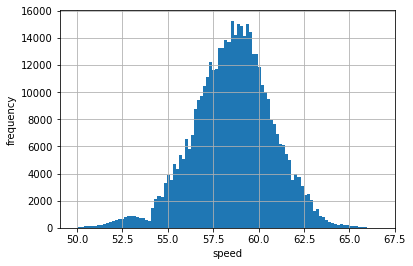

time: 422 ms


In [13]:
y_train.hist(bins=100);
plt.xlabel('speed');
plt.ylabel('frequency');

In [14]:
drop_columns = ['race_id', 'KettoNum', 'id$Year', 'speed']
X_test = test_data.drop(drop_columns, axis=1)
X_test

,Kyori,TenkoBaba$DirtBabaCD_0,TenkoBaba$SibaBabaCD_0,TenkoBaba$SibaBabaCD_1,TenkoBaba$DirtBabaCD_1,id$RaceNum,TrackCD_52,TrackCD_17,JyokenInfo$SyubetuCD_18,GradeCD_,...,KS_Syotai_フランス,KS_Syotai_川崎,KS_Syotai_笠松,id$JyoCD_1,KS_ChokyosiCode_365.0,CH_Syotai_川崎,top2_ChokyosiCode,top2_BanusiCode,top2_UM_BreederCode,before_Odds
0,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.398731,-0.216783,0.174543,-0.638874
1,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.415822,-0.318228,-1.717806,4.068149
2,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.351113,-2.011561,-0.232294,-0.547888
3,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.812923,-0.653485,-1.837928,0.188494
4,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.469803,-0.723257,-0.230315,-0.456902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19140,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.252109,1.811460,1.335489,-0.671629
19141,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.897933,2.023608,1.335489,-0.698319
19142,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.608380,0.873101,-1.450211,1.291248
19143,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.897933,0.945055,0.435675,-0.701958


time: 63 ms


In [15]:
y_test = test_data['speed']
y_test.describe()

count    19145.000000
mean        58.013408
std          2.305421
min         38.876890
25%         56.509695
50%         58.142665
75%         59.558824
max         65.573770
Name: speed, dtype: float64

time: 0 ns


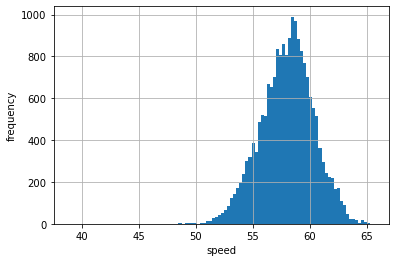

time: 282 ms


In [16]:
y_test.hist(bins=100);
plt.xlabel('speed');
plt.ylabel('frequency');

## 2. Train with ANN

- Create and compile Model

In [53]:
from tensorflow.keras import backend as K

def my_r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true) ) ) 
    return (1 - SS_res/(SS_tot + K.epsilon()) )

def BatchNorm():
    return BatchNormalization(
                momentum=0.95, 
                epsilon=0.005,
                beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
                gamma_initializer=Constant(value=0.9)
                )

def build_and_compile_model(X_train, num_units=100, activation='sigmoid'):
    input_shape = X_train.shape[1] 
    model = Sequential()
    model.add(Dense(units=num_units, activation=activation, kernel_initializer='he_normal',
                    input_shape=(input_shape,)))
    #model.add(Dropout(0.1))
    model.add(Dense(1))
      
    model.compile(loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(), my_r2_score], optimizer=Optimizer.Adam(0.01)) #my_r2_score
    
    return model


time: 0 ns


- Setup callback

In [54]:
class My_checkoint(Callback):
        
    def __init__(self, model, X_test, y_test, checkpoint_name):
        self.X_test = X_test
        self.y_test = y_test
        self.mode = model
    def on_epoch_end(self, epoch, logs=None):
        cpn = checkpoint_name + format(epoch, '02d') + '-.hdf5'
        #cpn = os.path.join(checkpoint_dir, 'model'+format(epoch, '02d') + '-.hdf5')
        val_loss = self.mode.evaluate(self.X_test, self.y_test)
        print('my_val_loss', val_loss)
        self.mode.save(cpn)
        
def callback_model(model, checkpoint_name, logdir, X_test, y_test):
  
    _logdir = os.path.join(logdir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(_logdir, histogram_freq=1)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.3,
                                  patience=1,
                                  mode='min',
                                  verbose=1)
    
    early_stopping = EarlyStopping(patience=7,
                                   monitor='val_loss',
                                   mode='min',
                                   verbose=1)
    
    csv_logger = CSVLogger('log.log', separator=',', append=False)
    
    callbacks_list = [tensorboard_callback, reduce_lr, early_stopping, csv_logger, My_checkoint(model, X_test, y_test, checkpoint_name)]
    
    return callbacks_list


time: 0 ns


- Create train model

In [55]:
def train_model(model, X_train, y_train, X_test, y_test, checkpoint_name, logdir, batch_size=32, epochs=10, re_train=True):

    if re_train:
        # Clear old folder
        %rmdir /q/s {logdir}
        # Clear old file
        path = checkpoint_name + '**'
        all_path_files = glob(path)
        for file in all_path_files:
            os.remove(file)
        # fit model
        callbacks_list = callback_model(model, checkpoint_name, logdir, X_test, y_test)
        model.fit(X_train, y_train,
                  validation_data=(X_test, y_test),
                  batch_size=batch_size,
                  epochs=epochs,
                  callbacks=callbacks_list)
        
        #del model
        
    # Get best file by reading log file
    df = pd.read_csv('log.log')
    best_epoch = df.loc[df['val_loss']==df['val_loss'].min(), 'epoch'].values[0]
    best_file = 'model-' + format(best_epoch, '02d') + '-.hdf5'
    #best_file = os.path.join(checkpoint_dir, 'model'+format(best_epoch, '02d') + '-.hdf5')
    model = load_model(best_file, custom_objects={'my_r2_score': my_r2_score})
    return model


time: 0 ns


- <span style="color:blue">Train với bộ thông số tốt nhất:
    - units: 260
    - batch_size: 112
    - activation: tanh
   

In [56]:
checkpoint_name = 'model-'
baseDir = os.path.abspath(os.getcwd())
logs_name = 'training_logs'
logdir = os.path.join(baseDir, logs_name)
#checkpoint_dir = os.path.join(baseDir, checkpoint_name)

time: 0 ns


In [57]:

model = build_and_compile_model(X_train, num_units=260, activation='tanh')

model = train_model(model, X_train, y_train, X_test, y_test, checkpoint_name, logdir,
                    batch_size=112, epochs=15, re_train=True)


Epoch 1/15
171/171 [==============================] - 0s 3ms/step - loss: 0.8095 - root_mean_squared_error: 0.8997 - my_r2_score: 0.7829
my_val_loss [0.8095368146896362, 0.8997426629066467, 0.7829455733299255]
4037/4037 [==============================] - 14s 3ms/step - loss: 7.4133 - root_mean_squared_error: 2.7227 - my_r2_score: -0.6465 - val_loss: 0.8095 - val_root_mean_squared_error: 0.8997 - val_my_r2_score: 0.7829
Epoch 2/15
4028/4037 [============================>.] - ETA: 0s - loss: 2.1679 - root_mean_squared_error: 1.4724 - my_r2_score: 0.5312
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
171/171 [==============================] - 0s 2ms/step - loss: 0.8831 - root_mean_squared_error: 0.9397 - my_r2_score: 0.7580
my_val_loss [0.8830680251121521, 0.9397169947624207, 0.7579670548439026]
4037/4037 [==============================] - 12s 3ms/step - loss: 2.1680 - root_mean_squared_error: 1.4724 - my_r2_score: 0.5311 - val_loss: 0.8831 - val_root_mean

- Evaluate model

In [58]:
# On train
train_result_df = evaluate(model, X_train, y_train_df)
#train_result_df

Sai số rmse:                    0.664
Hệ số xác định r2-score: 0.908
Tỉ lệ True positive:           0.400
time: 26.6 s


In [59]:
# On test
test_result_df = evaluate(model, X_test, y_test_df)
#test_result_df

Sai số rmse:                    0.875
Hệ số xác định r2-score: 0.856
Tỉ lệ True positive:           0.373
time: 531 ms


- <span style="color:blue">Nhận xét:
    Độ chính tập train được cải thiện, tuy nhiên tập test ko thay đổi

In [50]:
log_data = pd.read_csv('log.log')
log_data['epoch'] = log_data['epoch'] + 1
log_data

,epoch,loss,lr,my_r2_score,root_mean_squared_error,val_loss,val_my_r2_score,val_root_mean_squared_error
0,1,7.053571,1.000000e-02,-0.601827,2.655856,1.187730,0.671894,1.089830
1,2,1.664495,1.000000e-02,0.640300,1.290153,0.838544,0.766776,0.915721
2,3,1.586020,1.000000e-02,0.656849,1.259373,0.833012,0.771860,0.912695
3,4,1.502647,1.000000e-02,0.675298,1.225825,0.933898,0.739138,0.966384
4,5,1.373170,3.000000e-03,0.703197,1.171823,1.489730,0.576785,1.220545
5,6,1.318928,9.000000e-04,0.715144,1.148446,0.810347,0.777633,0.900193
6,7,1.301577,9.000000e-04,0.718435,1.140867,0.776818,0.787185,0.881373
7,8,1.280292,9.000000e-04,0.723322,1.131500,0.772641,0.788442,0.879000
8,9,1.266138,9.000000e-04,0.726285,1.125228,0.821982,0.773669,0.906632
9,10,1.246249,2.700000e-04,0.730441,1.116355,0.795432,0.781450,0.891870


time: 16 ms


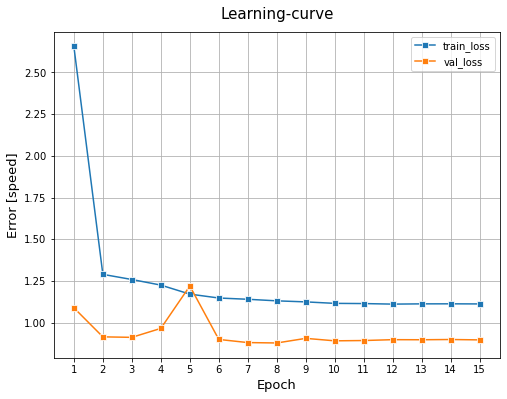

time: 313 ms


In [51]:
def plot_loss(log_data):
    plt.figure(figsize=(8, 6))
    #fig.add_subplot(1, 2, 1)
    sns.lineplot(x='epoch', y='root_mean_squared_error', data=log_data, marker='s', label='train_loss');
    sns.lineplot(x='epoch', y='val_root_mean_squared_error', data=log_data, marker='s', label='val_loss');
    plt.xlabel('Epoch', size=13)
    plt.xticks(np.arange(1, log_data['epoch'].max()+1, step=1))
    plt.ylabel('Error [speed]', size=13)
    plt.legend()
    plt.title('Learning-curve', size=15, y=1.02)
    plt.grid(True)

plot_loss(log_data)

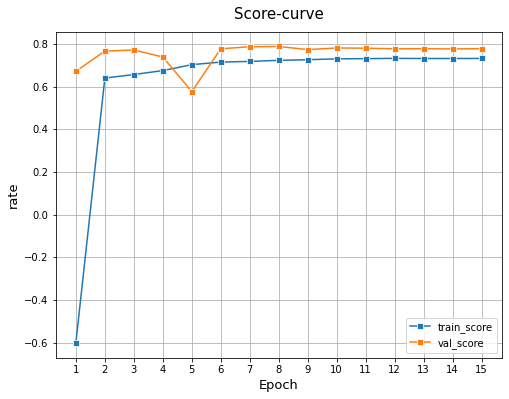

time: 312 ms


In [52]:
def plot_r2(log_data):
    plt.figure(figsize=(8, 6))
    #fig.add_subplot(1, 2, 1)
    sns.lineplot(x='epoch', y='my_r2_score', data=log_data, marker='s', label='train_score');
    sns.lineplot(x='epoch', y='val_my_r2_score', data=log_data, marker='s', label='val_score');
    plt.xlabel('Epoch', size=13)
    plt.xticks(np.arange(1, log_data['epoch'].max()+1, step=1))
    plt.ylabel('rate', size=13)
    plt.legend()
    plt.title('Score-curve', size=15, y=1.02)
    plt.grid(True)

plot_r2(log_data)

## 3. Tune parameter
- Điều chỉnh các siêu tham số bằng phương pháp BayesianOptimization

In [24]:
from kerastuner.tuners.bayesian import BayesianOptimization
from kerastuner import HyperModel

class RegressionHyperModel(HyperModel):
    
    def __init__(self, input_shape):
        self.input_shape = input_shape
        
    def build(self, hp):
        model = Sequential()
        model.add(
            Dense(
                units=hp.Int('units', 100, 300, 5, default=100),
                activation=hp.Choice(
                    'activation',
                    values=['relu', 'sigmoid', 'tanh'],
                    default='sigmoid'),
                kernel_initializer='he_normal',
                input_shape=self.input_shape
            )
        )
        model.add(Dense(1))
        model.compile(loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()],
                                           optimizer=Optimizer.Adam(0.01)) 
        return model
    
class MyTuner(BayesianOptimization):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 16, 128, step=16)
        #kwargs['epochs'] = trial.hyperparameters.Int('epochs', 10, 20, 5)
        super(MyTuner, self).run_trial(trial, *args, **kwargs)    
        

time: 0 ns


In [25]:

input_shape = (X_train.shape[1], )
hypermodel = RegressionHyperModel(input_shape)
project_name = 'fd_search'

tuner = MyTuner(
            hypermodel,
            objective='val_loss',
            max_trials=10,
            executions_per_trial=2,
            seed=42,
            project_name=project_name,
            overwrite=True
            )
tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=15, callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)], verbose=1)


Trial 10 Complete [00h 01m 58s]
val_loss: 0.8350815773010254

Best val_loss So Far: 0.7499967515468597
Total elapsed time: 00h 46m 54s
INFO:tensorflow:Oracle triggered exit
time: 46min 54s


- Get best hyperparameters

In [26]:
list_best_hp = tuner.get_best_hyperparameters(num_trials=3)
list_best_units = []
list_best_batch_size = []
list_best_activation = []

for best_hp in list_best_hp:
    best_units = best_hp.get('units')
    list_best_units.append(best_units)
    best_batch_size = best_hp.get('batch_size')
    list_best_batch_size.append(best_batch_size)
    best_activation = best_hp.get('activation')
    list_best_activation.append(best_activation)

hp_result = pd.DataFrame({'units':list_best_units,
                            'batch_size': list_best_batch_size,
                            'activation': list_best_activation
                            })
print('Các bộ tham số tốt nhất')
hp_result

Các bộ tham số tốt nhất


,units,batch_size,activation
0,175,96,tanh
1,185,128,tanh
2,260,112,tanh


time: 15 ms


- <span style="color:blue">Phương pháp:
    - Ta train lại 3 mô hình tốt nhất để đánh giá
   

In [33]:

list_val_loss = []
for num_units, activation, batch_size in zip(list_best_units, list_best_activation, list_best_batch_size):
    model = build_and_compile_model(X_train, num_units=num_units, activation=activation)
    model = train_model(model, X_train, y_train, X_test, y_test, checkpoint_name, logdir,
                        batch_size=batch_size, epochs=15, re_train=True)
    val_loss, _, _ = model.evaluate(X_test, y_test)
    list_val_loss.append(val_loss)
    

Epoch 1/15
   1/4709 [..............................] - ETA: 0s - loss: 3466.3311 - root_mean_squared_error: 58.8756 - my_r2_score: -768.6529WARNING:tensorflow:From C:\ProgramData\Anaconda3\envs\my_d2l\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
200/200 [==============================] - 0s 2ms/step - loss: 0.8713 - root_mean_squared_error: 0.9334 - my_r2_score: 0.7380
my_val_loss [0.871292769908905, 0.9334306716918945, 0.7380317449569702]
4709/4709 [==============================] - 15s 3ms/step - loss: 7.2999 - root_mean_squared_error: 2.7018 - my_r2_score: -0.6001 - val_loss: 0.8713 - val_root_mean_squared_error: 0.9334 - val_my_r2_score: 0.7380
Epoch 2/15
200/200 [==============================] - 0s 2ms/step - loss: 0.8277 - root_mean_squared_error: 0.9098 - my_r2_score: 0.7568
my_val_loss [0.82

In [34]:
filter_data_result = pd.DataFrame({'units':list_best_units,
                            'batch_size': list_best_batch_size,
                            'activation': list_best_activation,
                            'val_loss': list_val_loss})
filter_data_result

,units,batch_size,activation,val_loss
0,175,96,tanh,0.782739
1,185,128,tanh,0.747116
2,260,112,tanh,0.720717


time: 16 ms


In [35]:
# Save improve_result
filter_data_result.to_csv('filter_data_result.csv', index=False)

time: 15 ms


- <span style="color:blue">Ta chọn bộ tham số tốt nhất:
    - units: 260
    - batch_size: 112
    - activation: tanh
   

In [36]:
model = build_and_compile_model(X_train, num_units=260, activation='tanh')
model = train_model(model, X_train, y_train, X_test, y_test, checkpoint_name, logdir,
                        batch_size=112, epochs=15, re_train=True)
    

Epoch 1/15
171/171 [==============================] - 0s 2ms/step - loss: 0.7660 - root_mean_squared_error: 0.8752 - my_r2_score: 0.7887
my_val_loss [0.7659750580787659, 0.8751999735832214, 0.7887331247329712]
4037/4037 [==============================] - 14s 3ms/step - loss: 5.7225 - root_mean_squared_error: 2.3922 - my_r2_score: -0.1578 - val_loss: 0.7660 - val_root_mean_squared_error: 0.8752 - val_my_r2_score: 0.7887
Epoch 2/15
4027/4037 [============================>.] - ETA: 0s - loss: 0.5017 - root_mean_squared_error: 0.7083 - my_r2_score: 0.8915
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
171/171 [==============================] - 0s 2ms/step - loss: 0.9387 - root_mean_squared_error: 0.9689 - my_r2_score: 0.7367
my_val_loss [0.9387310743331909, 0.968881368637085, 0.7366563081741333]
4037/4037 [==============================] - 12s 3ms/step - loss: 0.5017 - root_mean_squared_error: 0.7083 - my_r2_score: 0.8915 - val_loss: 0.9387 - val_root_mean_

- Evaluate model

In [37]:
# On train
train_result_df = evaluate(model, X_train, y_train_df)

Sai số rmse:                    0.648
Hệ số xác định r2-score: 0.912
Tỉ lệ True positive:           0.418
time: 25 s


In [38]:
# On test
test_result_df = evaluate(model, X_test, y_test_df)

Sai số rmse:                    0.845
Hệ số xác định r2-score: 0.866
Tỉ lệ True positive:           0.385
time: 453 ms


In [40]:
log_data = pd.read_csv('log.log')
log_data['epoch'] = log_data['epoch'] + 1
log_data

,epoch,loss,lr,my_r2_score,root_mean_squared_error,val_loss,val_my_r2_score,val_root_mean_squared_error
0,1,5.722518,0.010000,-0.157803,2.392179,0.765975,0.788733,0.875200
1,2,0.501720,0.010000,0.891503,0.708322,0.938731,0.736656,0.968881
2,3,0.444827,0.003000,0.903845,0.666953,0.720640,0.802996,0.848905
3,4,0.434201,0.003000,0.906033,0.658939,0.713282,0.805655,0.844560
4,5,0.423324,0.003000,0.908467,0.650634,0.742123,0.796127,0.861466
5,6,0.392653,0.000900,0.915026,0.626620,0.746294,0.795834,0.863883
6,7,0.378159,0.000270,0.918240,0.614947,0.746744,0.796027,0.864144
7,8,0.373227,0.000081,0.919205,0.610923,0.743315,0.796652,0.862157
8,9,0.371548,0.000024,0.919621,0.609547,0.744268,0.796434,0.862710
9,10,0.370996,0.000007,0.919730,0.609094,0.743153,0.796688,0.862063


time: 0 ns


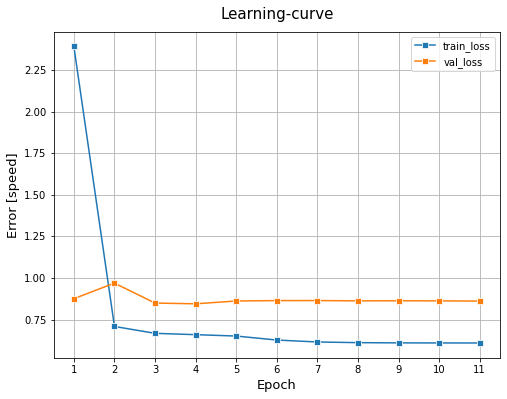

time: 344 ms


In [41]:
def plot_loss(log_data):
    plt.figure(figsize=(8, 6))
    #fig.add_subplot(1, 2, 1)
    sns.lineplot(x='epoch', y='root_mean_squared_error', data=log_data, marker='s', label='train_loss');
    sns.lineplot(x='epoch', y='val_root_mean_squared_error', data=log_data, marker='s', label='val_loss');
    plt.xlabel('Epoch', size=13)
    plt.xticks(np.arange(1, log_data['epoch'].max()+1, step=1))
    plt.ylabel('Error [speed]', size=13)
    plt.legend()
    plt.title('Learning-curve', size=15, y=1.02)
    plt.grid(True)

plot_loss(log_data)

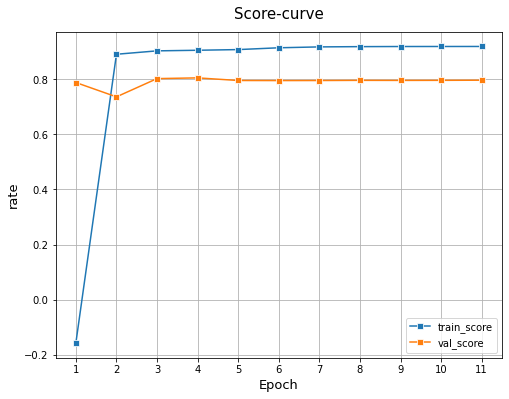

time: 281 ms


In [42]:
def plot_r2(log_data):
    plt.figure(figsize=(8, 6))
    #fig.add_subplot(1, 2, 1)
    sns.lineplot(x='epoch', y='my_r2_score', data=log_data, marker='s', label='train_score');
    sns.lineplot(x='epoch', y='val_my_r2_score', data=log_data, marker='s', label='val_score');
    plt.xlabel('Epoch', size=13)
    plt.xticks(np.arange(1, log_data['epoch'].max()+1, step=1))
    plt.ylabel('rate', size=13)
    plt.legend()
    plt.title('Score-curve', size=15, y=1.02)
    plt.grid(True)

plot_r2(log_data)